In [1]:
"""
Goals: 
- Generate USPORF tree structures in Python
- Apply IF scoring
- Reduce run time
"""

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import time
import random as rn
import os


In [7]:
"""
EXP 1:
Generate a sparse projected matrix `A` in [Algo 1].
"""
# n-samples; p-input features; d-projected features
n = 3000; p = 20; d = 5 

def projectA(p,d, Lambda = 1/20):
    A = np.matrix(np.random.choice(
        np.array([-1, 0, 1]), p*d, p=[Lambda/2, 1-Lambda, Lambda/2]
    ).reshape(p,d))
    
    return A


# Display-----------------------------------
display(projectA(4, 3))
X_raw = np.matrix(np.random.uniform(size = (n,p)))
print('X_raw: ', X_raw.shape)
A = projectA(p, d)
print('A: ', A.shape)
X_proj = np.dot(X_raw,A)
print('X_proj: ', X_proj.shape)
Z_mat = (X_proj[:,0])
Z_arr = np.array(Z_mat).reshape(Z_mat.shape[0]) # first col of X_proj -> into [Algo 3]

matrix([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 1],
        [0, 0, 0]])

X_raw:  (3000, 20)
A:  (20, 5)
X_proj:  (3000, 5)


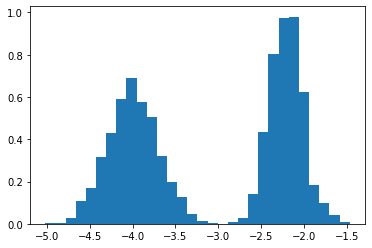

In [8]:
"""
EXP 2:
Generate `sample` = 2 nodes 1D array.
Use it to test the Spliting Algo. 3 in USPORF paper
"""
node1_1 = np.random.normal(-1-3, 0.3, size = n)
node1_2 = np.random.normal(0.8-3, 0.2, size = n)
node1_t = np.append(node1_1,node1_2)
sample = np.random.choice(node1_t, n)

# histrogram of `sample` -> split node should be ~ -3.0
plt.hist(sample, 30, density=True)
plt.show()

In [4]:
"""
EXP 3:
Test speed of arithmatric function
"""
num = 4*10**7

t_start = time.time()
x1 = np.linspace(0, num, num)
t_run = time.time()- t_start
print(x1.shape)
print('linspace t: ', t_run)

t_start = time.time()
x2 = np.arange(0, num) # np.arange is fastest
t_run = time.time()- t_start
print(x2.shape)
print('arange t: ', t_run)

t_start = time.time()
x3 = np.array(range(0, num)) 
t_run = time.time()- t_start
print(x3.shape)
print('range t: ', t_run)

(40000000,)
linspace t:  0.5478653907775879
(40000000,)
arange t:  0.3941683769226074
(40000000,)
range t:  11.093343734741211


In [10]:
"""
EXP 4:
Generate [Algo 3] the `Fast-BIC1D` spliting.
Use `for loop`
"""
def FastBIC(Z_arr):
    N = Z_arr.shape[0]
    Z_ind = np.argsort(Z_arr)
    minBIC = np.inf

    for s in range(2, (N+1)-2):
        Curr_1 = Z_arr[Z_ind[:s]]
        Curr_2 = Z_arr[Z_ind[s:]]
        var_1 = np.var(Curr_1)
        var_2 = np.var(Curr_2)
        if (var_1 == 0) or (var_2 == 0):
            continue
        
        n_1 = s
        n_2 = N-s
        pi_1 = s/N
        pi_2 = (N-s)/N
        var_comb = (pi_1*var_1 + pi_2*var_2)
        BIC_diff_var = -2*(n_1*np.log(pi_1)
                           - n_1/2*np.log(2*np.pi*var_1)
                           + n_2*np.log(pi_2)
                           - n_2/2*np.log(2*np.pi*var_2))
        BIC_same_var = -2*(n_1*np.log(pi_1)
                           - n_1/2*np.log(2*np.pi*var_comb)
                           + n_2*np.log(pi_2)
                           - n_2/2*np.log(2*np.pi*var_comb))
        BIC_curr = min(BIC_diff_var, BIC_same_var)

        if BIC_curr < minBIC:
            minBIC = BIC_curr
            #  splitPoint = (max(Curr_1) + min(Curr_2))/2
            splitPoint = (Z_arr[Z_ind[s-1]] + Z_arr[Z_ind[s]])/2
            
    return(splitPoint, minBIC)

# Display-----------------------------------
t_start = time.time()
fun = FastBIC(Z_arr = sample)
t_run = time.time() - t_start
print(fun)
print('t: ', t_run)

(-2.989199438669978, 1095.2250189867482)
t:  0.2330484390258789


In [11]:
"""
EXP 5:
Generate [Algo 3] the `Fast-BIC1D` spliting.
Using for `np.vectorize`
"""
# def FastBIC2(Zarr):
Z_arr = sample
# single variable
# Z_arr = sample
N = Z_arr.shape[0]
Z_ind = np.argsort(Z_arr)

# list variable
l_s = np.arange(2, (N+1)-2)  # from 2 to N-2
l_n_1 = l_s
l_n_2 = N - l_s
l_pi_1 = list_s/N
l_pi_2 = (N-list_s)/N

# regular functions
def f_var_1(s, Z_arr=Z_arr, Z_ind=Z_ind):
    Curr_1 = Z_arr[Z_ind[:s]]
    return np.var(Curr_1)

def f_var_2(s, Z_arr=Z_arr, Z_ind=Z_ind):
    Curr_2 = Z_arr[Z_ind[s:]]
    return np.var(Curr_2)

def f_var_comb(s, Z_arr=Z_arr, Z_ind=Z_ind):
    # pi_1 * var_1 + pi_2 * var_2
    return (s/N)*f_var_1(s, Z_arr, Z_ind)+ ((N-s)/N)*f_var_2(s, Z_arr, Z_ind)

def f_splitPoint(s, Z_arr=Z_arr, Z_ind=Z_ind):
    # (max(Curr_1) + min(Curr_2))/2
    return (Z_arr[Z_ind[s-1]] + Z_arr[Z_ind[s]])/2

# vetorize functions 
# Input: array  |  Output: array 
vf_var_1 = np.vectorize(f_var_1)
vf_var_2 = np.vectorize(f_var_2)
vf_var_comb = np.vectorize(f_var_comb)
vf_splitPoint = np.vectorize(f_splitPoint)

# list variable 2
l_var_1 = vf_var_1(l_s)
l_var_2 = vf_var_2(l_s)
l_var_comb = vf_var_comb(l_s)
l_splitPoint = vf_splitPoint(l_s)

l_BIC_diff_var = -2*(l_n_1*np.log(l_pi_1)
                   - l_n_1/2*np.log(2*np.pi*l_var_1)
                   + l_n_2*np.log(l_pi_2)
                   - l_n_2/2*np.log(2*np.pi*l_var_2))
l_BIC_same_var = -2*(l_n_1*np.log(l_pi_1)
                   - l_n_1/2*np.log(2*np.pi*l_var_comb)
                   + l_n_2*np.log(l_pi_2)
                   - l_n_2/2*np.log(2*np.pi*l_var_comb))

min_BIC_diff_var = min(l_BIC_diff_var)
min_BIC_same_var = min(l_BIC_same_var)

if min_BIC_diff_var <= min_BIC_same_var:
    BIC_curr2 = min_BIC_diff_var
    splitPoint2 = l_splitPoint[np.where(l_BIC_diff_var == min_BIC_diff_var)]
else:
    BIC_curr2 = min_BIC_same_var
    splitPoint2 = l_splitPoint[np.where(l_BIC_same_var == min_BIC_diff_var)]

print(BIC_curr2, splitPoint2)

# Display-----------------------------------
# t_start = time.time()
# fun = FastBIC2(sample)
# t_run = time.time() - t_start
# print(fun)
# print('t: ', t_run)

NameError: name 'list_s' is not defined

In [ ]:
# def outer(num1):
#     def inner_increment(num1):  # Hidden from outer code
#         return num1 + 1
#     num2 = inner_increment(num1)
#     print(num1, num2)

# # inner_increment(10)
# outer(10)

In [ ]:
# x = np.array([1., -1., -2., 3])
# print(x)
# y = x[x < 0] 
# print(y)